In [0]:
#  https://www.kaggle.com/lpanda/netflix-data

In [1]:
from pyspark.sql import *
import pyspark.sql.functions as F
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np

# import dask.dataframe as dd # asynchronous load and subset which is useful for large dataset sampling
# from dask.distributed import Client

# # visualization
# import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style="whitegrid", context='paper')
# sns.set(rc={'figure.figsize':(18,5)})

# from functools import wraps # a ditty decorator

# from sklearn.metrics.pairwise import cosine_similarity

import random # random integers
import os # i/o read files
import time # time my work
import gc  # clear ram

In [2]:
# Mount drive
import os
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Colab Notebooks/privacy'

print(os.listdir())

ModuleNotFoundError: No module named 'google.colab'

In [2]:
%load_ext autoreload
%autoreload 1

%aimport privacy_spark

In [3]:
spark = SparkSession \
    .builder \
    .appName("Privacy Project") \
    .getOrCreate()
df = spark.read.csv("ratings.csv", inferSchema = True, header = True)
df.schema

StructType(List(StructField(movieId,IntegerType,true),StructField(custId,IntegerType,true),StructField(rating,IntegerType,true),StructField(date,TimestampType,true)))

Row(custId=305344, count=17653)


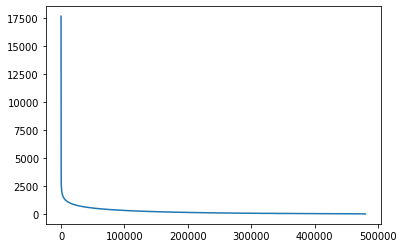

In [4]:
nb_reviews = df.groupBy("custId").count().collect()
nb_reviews.sort(key=lambda row: row["count"], reverse=True)
print(nb_reviews[0])
plt.plot([x["count"] for x in nb_reviews]) #if x["count"] < 1000])

In [5]:
MIN_DATE = df.agg({'date': 'min'}).collect()[0]["min(date)"]
MAX_DATE = df.agg({'date': 'max'}).collect()[0]["max(date)"]
print(MIN_DATE)
print(MAX_DATE)
print((MAX_DATE - MIN_DATE).days)

1999-11-11 00:00:00
2005-12-31 00:00:00
2242


In [6]:
df = df.withColumn('days', (((F.col('date').cast('long') - MIN_DATE.timestamp())/(3600*24)).cast("long")))
df = df.drop('date')
df.head()

Row(movieId=1, custId=1488844, rating=3, days=2125)

In [7]:
chosen_cust = 1935793

aux_list = [privacy_spark.Auxiliary(True, True, 1, 5), privacy_spark.Auxiliary(True, True, 1, 5)]
aux = privacy_spark.Generate.generate(df, aux_list, custId=chosen_cust)
aux

[Row(movieId=1, custId=1935793, rating=1, days=1984), Row(movieId=3, custId=1935793, rating=1, days=1959), Row(movieId=5, custId=1935793, rating=3, days=1984), Row(movieId=6, custId=1935793, rating=1, days=1959), Row(movieId=8, custId=1935793, rating=1, days=2231), Row(movieId=12, custId=1935793, rating=3, days=1876), Row(movieId=18, custId=1935793, rating=3, days=1943), Row(movieId=19, custId=1935793, rating=1, days=1977), Row(movieId=20, custId=1935793, rating=1, days=1977), Row(movieId=27, custId=1935793, rating=1, days=1987), Row(movieId=29, custId=1935793, rating=1, days=1954), Row(movieId=30, custId=1935793, rating=3, days=1847), Row(movieId=36, custId=1935793, rating=1, days=1970), Row(movieId=44, custId=1935793, rating=3, days=1955), Row(movieId=45, custId=1935793, rating=2, days=1922), Row(movieId=47, custId=1935793, rating=1, days=1888), Row(movieId=50, custId=1935793, rating=2, days=1976), Row(movieId=56, custId=1935793, rating=1, days=1869), Row(movieId=57, custId=1935793, 

,movieId,custId,rating,days
0,2379,1935793,3,2188
0,11664,1935793,3,2035


In [8]:
scoring = privacy_spark.Scoreboard_RH(privacy_spark.general_similarity(), df)
scores = scoring.compute_score(spark.createDataFrame(aux), df).cache()
scores

DataFrame[custId_2: int, value: double]

In [9]:
scores.take(5)

[Row(custId_2=1935793, value=0.5666574849654078),
 Row(custId_2=1265763, value=0.3927260799543054),
 Row(custId_2=1868599, value=0.34786281002220487),
 Row(custId_2=41412, value=0.34786281002220487),
 Row(custId_2=2511993, value=0.34786281002220487)]

In [10]:
scoring.matching_set(scores, 0.5)
# scoring.output(scores, 0.5)

0.056610158896491736


(Row(custId_2=1935793, value=0.5666574849654078), 3.07244156175441)